In [1]:
# --- CÉLULA 1: CONFIGURAÇÃO E PREPARAÇÃO INICIAL ---

# Carregar bibliotecas essenciais
library(readr)  # Para carregar dados
library(dplyr)  # Para manipulação de dados (Feature Engineering)
library(caret)  # Para particionamento e avaliação
library(pROC)   # Para Curva ROC e cálculo de AUC

# 1. Carregar o dataset insurance.csv
insurance_data <- read_csv("./data/insurance.csv")

# 2. Inspecionar a estrutura
cat("Dimensões do Dataset:", dim(insurance_data), "\n")


Anexando pacote: 'dplyr'


Os seguintes objetos são mascarados por 'package:stats':

    filter, lag


Os seguintes objetos são mascarados por 'package:base':

    intersect, setdiff, setequal, union


Carregando pacotes exigidos: ggplot2

Carregando pacotes exigidos: lattice

Type 'citation("pROC")' for a citation.


Anexando pacote: 'pROC'


Os seguintes objetos são mascarados por 'package:stats':

    cov, smooth, var


Rows: 1338 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (4): age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Dimensões do Dataset: 1338 7 


In [2]:
# --- CÉLULA 2: ENGENHARIA DA VARIÁVEL ALVO (high_cost) ---

# 1. Definir o Limiar de Alto Custo (75º Percentil ou Q3)
# Clientes com charges acima deste valor serão classificados como 'Alto Risco' (1).
q3_charges <- quantile(insurance_data$charges, 0.75)
cat("O Limiar de Alto Custo (Q3) é:", round(q3_charges, 2), "\n")

# 2. Criar a nova variável binária 'high_cost' (Target Y)
insurance_data <- insurance_data %>%
  mutate(
    # TRUE se charges > Q3, FALSE caso contrário
    high_cost = ifelse(charges > q3_charges, "Alto_Risco", "Normal")
  ) %>%
  # Converter o alvo para um fator (necessário para modelos de classificação em R)
  mutate(high_cost = factor(high_cost, levels = c("Normal", "Alto_Risco"))) %>%
  # Remover a variável original 'charges' para evitar vazamento de dados (data leakage)
  select(-charges)

# 3. Verificar o balanceamento da nova variável alvo
cat("\nBalanceamento da Classe 'high_cost':\n")
print(table(insurance_data$high_cost))

O Limiar de Alto Custo (Q3) é: 16639.91 

Balanceamento da Classe 'high_cost':

    Normal Alto_Risco 
      1003        335 


In [3]:
# --- CÉLULA 3: PRÉ-PROCESSAMENTO E PARTICIONAMENTO ESTRATIFICADO ---

set.seed(42)
# createDataPartition fará uma divisão estratificada (mantém a proporção do alvo)
train_index <- createDataPartition(insurance_data$high_cost, p = 0.7, list = FALSE) 

train_data <- insurance_data[train_index, ]
test_data <- insurance_data[-train_index, ]

# 1. Pré-processamento: Dummies para categóricas e Z-Score (center/scale) para numéricas
# Usamos o 'charges ~ .' para incluir todas as variáveis, menos 'charges' (que foi removida na Célula 2)
pre_process_model <- preProcess(
    train_data %>% select(-high_cost),
    method = c("center", "scale", "zv") 
# "center" e "scale" para Padronização (Z-Score) e "zv" para remover variáveis de variância zero (Zero Variance)
)

# Aplicar a transformação no treino e teste
train_processed <- predict(pre_process_model, train_data)
test_processed <- predict(pre_process_model, test_data)

cat("Dimensões do Set de Treino Processado:", dim(train_processed), "\n")

Dimensões do Set de Treino Processado: 938 7 


In [4]:
# --- CÉLULA 4: TREINAMENTO DA REGRESSÃO LOGÍSTICA ---

# A Regressão Logística é um modelo linear generalizado (GLM) com família binomial
logreg_model <- glm(
    high_cost ~ age + sex + bmi + children + smoker + region,
    data = train_processed,
    family = "binomial" # Define o modelo para classificação binária
)

cat("Sumário do Modelo de Regressão Logística:\n")
# Analise os P-valores e a significância dos coeficientes (Age, Smoker, BMI)
print(summary(logreg_model))

# 1. Fazer previsões de PROBABILIDADE no set de teste
# type="response" retorna a probabilidade P(Y=1 | X)
probabilities_test <- predict(
    logreg_model,
    newdata = test_processed,
    type = "response"
)

Sumário do Modelo de Regressão Logística:

Call:
glm(formula = high_cost ~ age + sex + bmi + children + smoker + 
    region, family = "binomial", data = train_processed)

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -2.56700    0.30082  -8.533  < 2e-16 ***
age              0.47801    0.14208   3.364 0.000767 ***
sexmale         -0.11175    0.26304  -0.425 0.670941    
bmi              0.31932    0.13674   2.335 0.019531 *  
children         0.13752    0.12432   1.106 0.268658    
smokeryes        5.78865    0.39074  14.815  < 2e-16 ***
regionnorthwest -0.01247    0.37653  -0.033 0.973588    
regionsoutheast  0.10613    0.36625   0.290 0.771996    
regionsouthwest -0.45854    0.38851  -1.180 0.237903    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1056.04  on 937  degrees of freedom
Residual deviance:  446.91  on 929  degrees of freedom
AIC: 464

--- Matriz de Confusão (Threshold 0.5) ---
Confusion Matrix and Statistics

            Reference
Prediction   Normal Alto_Risco
  Normal        291         25
  Alto_Risco      9         75
                                          
               Accuracy : 0.915           
                 95% CI : (0.8832, 0.9404)
    No Information Rate : 0.75            
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7606          
                                          
 Mcnemar's Test P-Value : 0.0101          
                                          
            Sensitivity : 0.7500          
            Specificity : 0.9700          
         Pos Pred Value : 0.8929          
         Neg Pred Value : 0.9209          
             Prevalence : 0.2500          
         Detection Rate : 0.1875          
   Detection Prevalence : 0.2100          
      Balanced Accuracy : 0.8600          
                                   

Setting direction: controls < cases



Área Sob a Curva ROC (AUC): 0.8669 


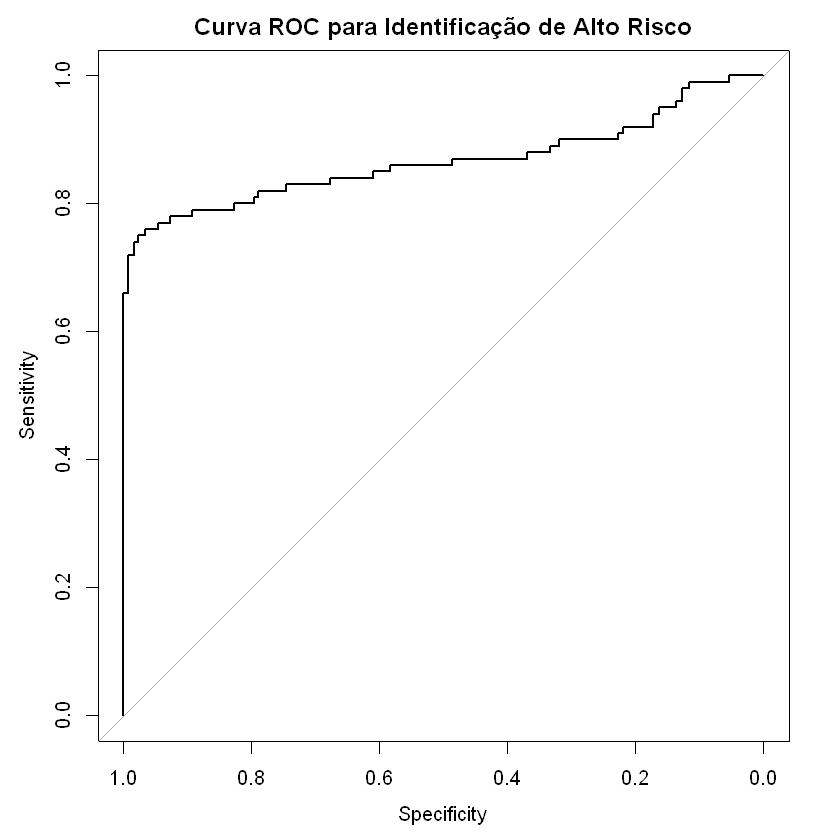

In [5]:
# --- CÉLULA 5: AVALIAÇÃO FOCADA EM RECALL E AUC ---

# --- A. Análise de Desempenho (Confusion Matrix) ---

# 1. Converter Probabilidades para Classes (Usando o threshold padrão de 0.5)
# Note: Para maximizar o Recall, um Analista de Dados ajustaria esse threshold!
predicted_classes <- factor(
    ifelse(probabilities_test > 0.5, "Alto_Risco", "Normal"),
    levels = c("Normal", "Alto_Risco")
)

# 2. Calcular a Matriz de Confusão
conf_matrix <- confusionMatrix(
    data = predicted_classes,
    reference = test_processed$high_cost,
    positive = "Alto_Risco" # Define qual classe é de interesse (a positiva)
)

cat("--- Matriz de Confusão (Threshold 0.5) ---\n")
print(conf_matrix)
cat("\nRecall (Sensibilidade):", conf_matrix$byClass['Recall'], "\n")

# --- B. Análise de AUC (Desempenho Geral do Modelo) ---

# 3. Calcular a Curva ROC e AUC
roc_curve <- roc(
    response = test_processed$high_cost,
    predictor = probabilities_test,
    levels = c("Normal", "Alto_Risco")
)

# 4. Plotar Curva ROC 
plot(roc_curve, main = "Curva ROC para Identificação de Alto Risco") 

# 5. Exibir o Valor AUC (Métrica mais robusta contra desbalanceamento)
cat("Área Sob a Curva ROC (AUC):", round(auc(roc_curve), 4), "\n")